In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
# all_slow

In [ ]:
#default_exp medical.imaging

# Medical Imaging

> Helpers for working with DICOM files

In [ ]:
#export 
from fastai.basics import *
from fastai.vision.all import *
from fastai.data.transforms import *

import pydicom,kornia,skimage
from pydicom.dataset import Dataset as DcmDataset
from pydicom.tag import BaseTag as DcmTag
from pydicom.multival import MultiValue as DcmMultiValue
from PIL import Image

try:
    import cv2
    cv2.setNumThreads(0)
except: pass

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
matplotlib.rcParams['image.cmap'] = 'bone'

In [ ]:
#export
_all_ = ['DcmDataset', 'DcmTag', 'DcmMultiValue', 'dcmread', 'get_dicom_files']

## Patching

In [ ]:
#export
def get_dicom_files(path, recurse=True, folders=None):
    "Get dicom files in `path` recursively, only in `folders`, if specified."
    return get_files(path, extensions=[".dcm"], recurse=recurse, folders=folders)

In [ ]:
#export
@patch
def dcmread(fn:Path, force = False):
    "Open a `DICOM` file"
    return pydicom.dcmread(str(fn), force)

`fastai.medical.imaging` uses `pydicom.dcmread` to read a DICOM file. To view the `header` of a DICOM, specify the `path` of a test file and call `dcmread`.

In [ ]:
TEST_DCM = Path('images/sample.dcm')
dcm = TEST_DCM.dcmread()
dcm

(0008, 0018) SOP Instance UID                    UI: ID_e0cc6a4b5
(0008, 0060) Modality                            CS: 'CT'
(0010, 0020) Patient ID                          LO: 'ID_a107dd7f'
(0020, 000d) Study Instance UID                  UI: ID_6468bdd34a
(0020, 000e) Series Instance UID                 UI: ID_4be303ae64
(0020, 0010) Study ID                            SH: ''
(0020, 0032) Image Position (Patient)            DS: [-125.000, -122.268, 115.936]
(0020, 0037) Image Orientation (Patient)         DS: [1.000000, 0.000000, 0.000000, 0.000000, 0.978148, -0.207912]
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME2'
(0028, 0010) Rows                                US: 256
(0028, 0011) Columns                             US: 256
(0028, 0030) Pixel Spacing                       DS: [0.488281, 0.488281]
(0028, 0100) Bits Allocated                      US: 16
(0028, 0101) Bits Stored                         US: 16

In [ ]:
type(dcm)

pydicom.dataset.FileDataset

In [ ]:
#export
class TensorDicom(TensorImage):
    "Inherits from `TensorImage` and converts the `pixel_array` into a `TensorDicom`"
    _show_args = {'cmap':'gray'}

In [ ]:
#export
class PILDicom(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        "Open a `DICOM file` from path `fn` or bytes `fn` and load it as a `PIL Image`"
        if isinstance(fn,bytes): im = Image.fromarray(pydicom.dcmread(pydicom.filebase.DicomBytesIO(fn)).pixel_array)
        if isinstance(fn,(Path,str)): im = Image.fromarray(dcmread(fn).pixel_array)
        im.load()
        im = im._new(im.im)
        return cls(im.convert(mode) if mode else im)

PILDicom._tensor_cls = TensorDicom

In [ ]:
# #export
# @patch
# def png16read(self:Path): return array(Image.open(self), dtype=np.uint16)

In [ ]:
#export
@patch(as_prop=True)
def pixels(self:DcmDataset):
    "`pixel_array` as a tensor"
    return tensor(self.pixel_array.astype(np.float32))

In [ ]:
pixels(dcm)

tensor([[-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
        ...,
        [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.],
        [-1024., -1024., -1024.,  ..., -1024., -1024., -1024.]])

In [ ]:
#export
@patch(as_prop=True)
def scaled_px(self:DcmDataset):
    "`pixels` scaled by `RescaleSlope` and `RescaleIntercept`"
    img = self.pixels
    if hasattr(self, 'RescaleSlope') and hasattr(self, 'RescaleIntercept') is not None:
        return img * self.RescaleSlope + self.RescaleIntercept 
    else: return img

`scaled_px` uses `RescaleSlope` and `RescaleIntercept` values to correctly scale the image so that they represent the correct tissue densities. You can observe what `scaled_px` does by viewing the the pixel distribution of a dicom image.  The histogram below displays the current pixel distribution which shows a pixel range between `-1133` and `2545`.

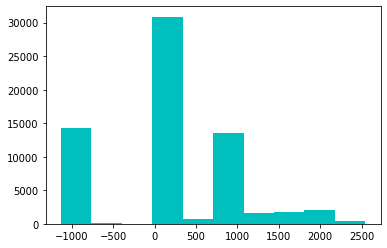

In [ ]:
px = dcm.pixels.flatten(); plt.hist(px, color='c');

As shown in the `header` of the test image the `RescaleIntercept` has a value of `-1024.0` and a `RescaleSlope` value of `1.0`. `scaled_px` will scale the pixels by these values.

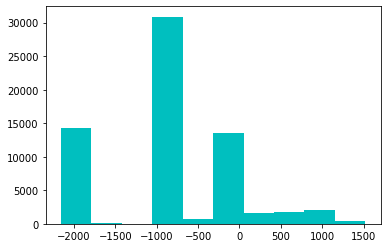

In [ ]:
scaled_px_values = scaled_px(dcm); plt.hist(scaled_px_values.flatten(), color='c');

The pixel distibution is now between `-2157` and `1521`

In [ ]:
#export
def array_freqhist_bins(self, n_bins=100):
    "A numpy based function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = np.sort(self.flatten())
    t = np.array([0.001])
    t = np.append(t, np.arange(n_bins)/n_bins+(1/2/n_bins))
    t = np.append(t, 0.999)
    t = (len(imsd)*t+0.5).astype(np.int)
    return np.unique(imsd[t])

In [ ]:
#export
@patch
def freqhist_bins(self:Tensor, n_bins=100):
    "A function to split the range of pixel values into groups, such that each group has around the same number of pixels"
    imsd = self.view(-1).sort()[0]
    t = torch.cat([tensor([0.001]),
                   torch.arange(n_bins).float()/n_bins+(1/2/n_bins),
                   tensor([0.999])])
    t = (len(imsd)*t).long()
    return imsd[t].unique()

For example with `n_bins` set to `1` this means the bins will be split into 3 distinct bins (the beginning, the end and the number of bins specified by `n_bins`.

In [ ]:
t_bin = pixels(dcm).freqhist_bins(n_bins=1)
t_bin

tensor([-1076.,    40.,  2375.])

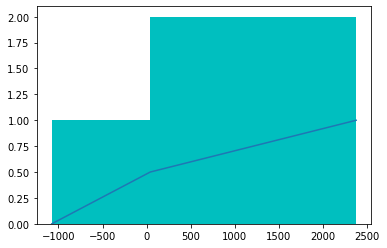

In [ ]:
plt.hist(t_bin, bins=t_bin, color='c'); plt.plot(t_bin, torch.linspace(0,1,len(t_bin)));

with `n_bins` at 100

In [ ]:
t_bin = pixels(dcm).freqhist_bins(n_bins=100)
t_bin

tensor([-1076., -1026., -1024., -1021.,    28.,    30.,    31.,    32.,    33.,
           34.,    35.,    36.,    37.,    38.,    39.,    40.,    41.,    42.,
           44.,    48.,    52.,    58.,    66.,    72.,    76.,    80.,    85.,
           91.,    94.,    98.,   103.,   111.,   123.,   161.,   219.,   478.,
          829.,   999.,  1027.,  1038.,  1044.,  1047.,  1049.,  1050.,  1051.,
         1052.,  1053.,  1054.,  1055.,  1056.,  1057.,  1058.,  1059.,  1060.,
         1062.,  1066.,  1108.,  1265.,  1453.,  1616.,  1741.,  1838.,  1943.,
         2051.,  2220.,  2375.])

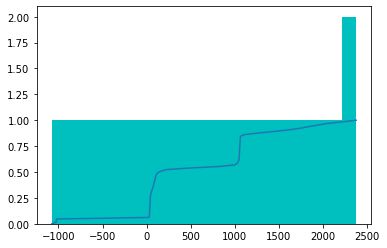

In [ ]:
plt.hist(t_bin, bins=t_bin, color='c'); plt.plot(t_bin, torch.linspace(0,1,len(t_bin)));

In [ ]:
#export
@patch
def hist_scaled_pt(self:Tensor, brks=None):
    # Pytorch-only version - switch to this if/when interp_1d can be optimized
    if brks is None: brks = self.freqhist_bins()
    brks = brks.to(self.device)
    ys = torch.linspace(0., 1., len(brks)).to(self.device)
    return self.flatten().interp_1d(brks, ys).reshape(self.shape).clamp(0.,1.)

In [ ]:
#export
@patch
def hist_scaled(self:Tensor, brks=None):
    "Scales a tensor using `freqhist_bins` to values between 0 and 1"
    if self.device.type=='cuda': return self.hist_scaled_pt(brks)
    if brks is None: brks = self.freqhist_bins()
    ys = np.linspace(0., 1., len(brks))
    x = self.numpy().flatten()
    x = np.interp(x, brks.numpy(), ys)
    return tensor(x).reshape(self.shape).clamp(0.,1.)

The test image has pixel values that range between `-1000` and `2500`

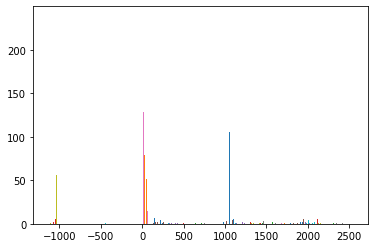

In [ ]:
_ = plt.hist(pixels(dcm), bins=100)

`hist_scaled` provides a way of scaling the input pixel values to between `0` and `1`

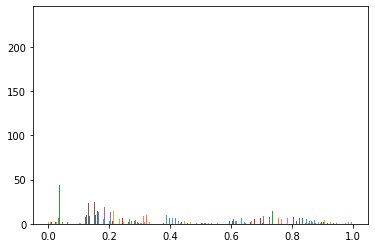

In [ ]:
tensor_hists = pixels(dcm).hist_scaled(); _ = plt.hist(tensor_hists, bins=100)

In [ ]:
#export
@patch
def hist_scaled(self:DcmDataset, brks=None, min_px=None, max_px=None):
    "Pixels scaled to a `min_px` and `max_px` value"
    px = self.scaled_px
    if min_px is not None: px[px<min_px] = min_px
    if max_px is not None: px[px>max_px] = max_px
    return px.hist_scaled(brks=brks)

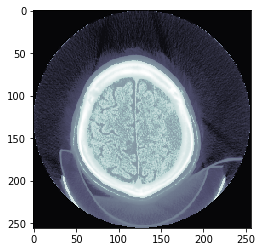

In [ ]:
data_scaled = dcm.hist_scaled()
plt.imshow(data_scaled, cmap=plt.cm.bone);

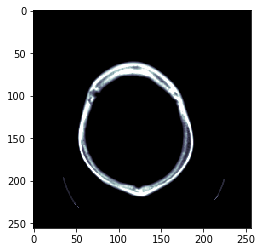

In [ ]:
data_scaled = dcm.hist_scaled(min_px=100, max_px=1000)
plt.imshow(data_scaled, cmap=plt.cm.bone);

Dicom images can contain a high amount of voxel values and windowing can be thought of as a means of manipulating these values in order to change the apperance of the image so particular structures are highlighted. A window has 2 values:

- `l` = window level or center aka brightness
- `w` = window width or range aka contrast

In [ ]:
#export
@patch
def windowed(self:Tensor, w, l):
    "Scale pixel intensity by window width and window level"
    px = self.clone()
    px_min = l - w//2
    px_max = l + w//2
    px[px<px_min] = px_min
    px[px>px_max] = px_max
    return (px-px_min) / (px_max-px_min)

In [ ]:
#export
@patch
def windowed(self:DcmDataset, w, l):
    return self.scaled_px.windowed(w,l)

In [ ]:
#export
# From https://radiopaedia.org/articles/windowing-ct
dicom_windows = types.SimpleNamespace(
    brain=(80,40),
    subdural=(254,100),
    stroke=(8,32),
    brain_bone=(2800,600),
    brain_soft=(375,40),
    lungs=(1500,-600),
    mediastinum=(350,50),
    abdomen_soft=(400,50),
    liver=(150,30),
    spine_soft=(250,50),
    spine_bone=(1800,400)
)

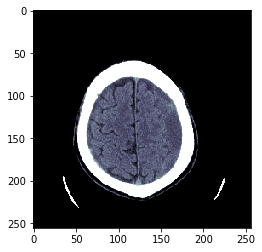

In [ ]:
plt.imshow(dcm.windowed(*dicom_windows.brain), cmap=plt.cm.bone);

In [ ]:
#export
class TensorCTScan(TensorImageBW): 
    "Inherits from `TensorImageBW` and converts the `pixel_array` into a `TensorCTScan`"
    _show_args = {'cmap':'bone'}

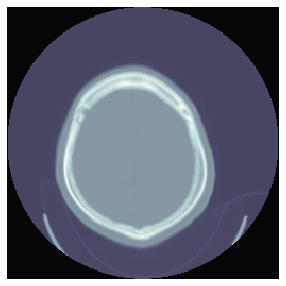

In [ ]:
tensor_ct = TensorCTScan(dcm.pixel_array)
tensor_ct.show();

In [ ]:
#export
class PILCTScan(PILBase): _open_args,_tensor_cls,_show_args = {},TensorCTScan,TensorCTScan._show_args

In [ ]:
#export
@patch
@delegates(show_image)
def show(self:DcmDataset, scale=True, cmap=plt.cm.bone, min_px=-1100, max_px=None, **kwargs):
    "Display a normalized dicom image by default"
    px = (self.windowed(*scale) if isinstance(scale,tuple)
          else self.hist_scaled(min_px=min_px,max_px=max_px,brks=scale) if isinstance(scale,(ndarray,Tensor))
          else self.hist_scaled(min_px=min_px,max_px=max_px) if scale
          else self.scaled_px)
    show_image(px, cmap=cmap, **kwargs)

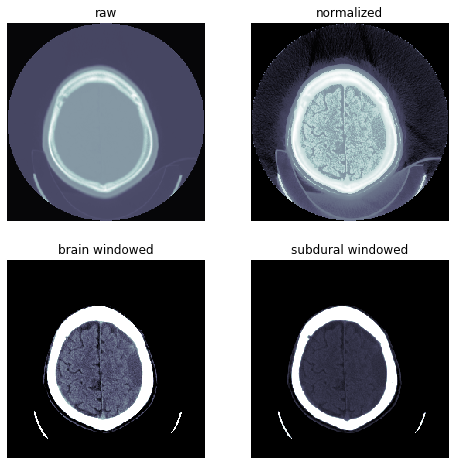

In [ ]:
scales = False, True, dicom_windows.brain, dicom_windows.subdural
titles = 'raw','normalized','brain windowed','subdural windowed'
for s,a,t in zip(scales, subplots(2,2,imsize=4)[1].flat, titles):
    dcm.show(scale=s, ax=a, title=t)

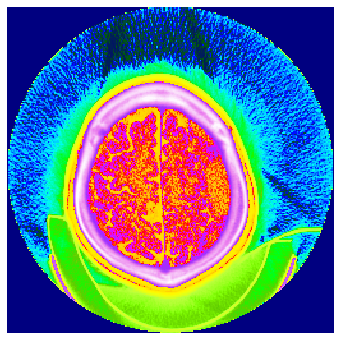

In [ ]:
dcm.show(cmap=plt.cm.gist_ncar, figsize=(6,6))

Some dicom datasets such as the [The Thyroid Segmentation in Ultrasonography Dataset](https://opencas.webarchiv.kit.edu/?q=node/29) is a dataset where each image has multiple frames per file (hundreds in this case). By default the `show` function will display 1 frame but if the dataset has multiple frames you can specify the number of frames to view.

In [ ]:
#export
@patch
@delegates(show_image, show_images)
def show(self:DcmDataset, frames=1, scale=True, cmap=plt.cm.bone, min_px=-1100, max_px=None, **kwargs):
    "Adds functionality to view dicom images where each file may have more than 1 frame"
    px = (self.windowed(*scale) if isinstance(scale,tuple)
          else self.hist_scaled(min_px=min_px,max_px=max_px,brks=scale) if isinstance(scale,(ndarray,Tensor))
          else self.hist_scaled(min_px=min_px,max_px=max_px) if scale
          else self.scaled_px)
    if px.ndim > 2:
        gh=[]
        p = px.shape; print(f'{p[0]} frames per file')
        for i in range(frames): u = px[i]; gh.append(u)
        show_images(gh, **kwargs)
    else:
        show_image(px, cmap=cmap, **kwargs)

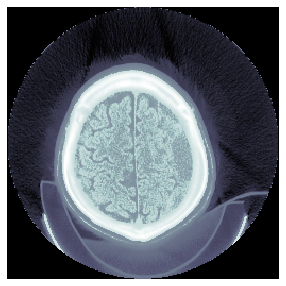

In [ ]:
dcm.show()

In [ ]:
#export
@patch
def pct_in_window(dcm:DcmDataset, w, l):
    "% of pixels in the window `(w,l)`"
    px = dcm.scaled_px
    return ((px > l-w//2) & (px < l+w//2)).float().mean().item()

In [ ]:
dcm.pct_in_window(*dicom_windows.brain)

0.19049072265625

`pct_in_window` can be used to check what percentage of the image is composed of meaningful pixels (pixels within the specified window)

In [ ]:
#export
def uniform_blur2d(x,s):
    "Uniformly apply blurring"
    w = x.new_ones(1,1,1,s)/s
    # Factor 2d conv into 2 1d convs
    x = unsqueeze(x, dim=0, n=4-x.dim())
    r = (F.conv2d(x, w, padding=s//2))
    r = (F.conv2d(r, w.transpose(-1,-2), padding=s//2)).cpu()[:,0]
    return r.squeeze()

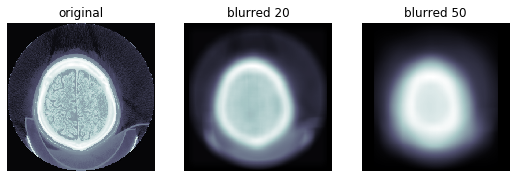

In [ ]:
ims = dcm.hist_scaled(), uniform_blur2d(dcm.hist_scaled(), 20), uniform_blur2d(dcm.hist_scaled(), 50)
show_images(ims, titles=('original', 'blurred 20', 'blurred 50'))

In [ ]:
#export
def gauss_blur2d(x,s):
    "Apply gaussian_blur2d kornia filter"
    s2 = int(s/4)*2+1
    x2 = unsqueeze(x, dim=0, n=4-x.dim())
    res = kornia.filters.gaussian_blur2d(x2, (s2,s2), (s,s), 'replicate')
    return res.squeeze()

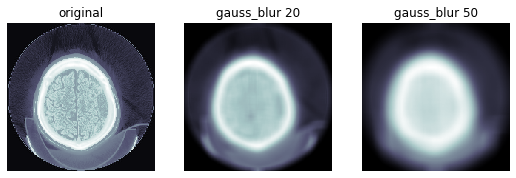

In [ ]:
ims = dcm.hist_scaled(), gauss_blur2d(dcm.hist_scaled(), 20), gauss_blur2d(dcm.hist_scaled(), 50)
show_images(ims, titles=('original', 'gauss_blur 20', 'gauss_blur 50'))

Images are often affected by random variations in intensity values, called noise. Gaussian noise contains variatons in intensity that are drawn from a Gaussian or normal distribution.  A Guassian filter is usually used to blur edges and remove smaller or thinner areas  in order to preserve the most important information

In [ ]:
#export
@patch
def mask_from_blur(x:Tensor, window, sigma=0.3, thresh=0.05, remove_max=True):
    "Create a mask from the blurred image"
    p = x.windowed(*window)
    if remove_max: p[p==1] = 0
    return gauss_blur2d(p, s=sigma*x.shape[-1])>thresh

In [ ]:
#export
@patch
def mask_from_blur(x:DcmDataset, window, sigma=0.3, thresh=0.05, remove_max=True):
    "Create a mask from the blurred image"
    return to_device(x.scaled_px).mask_from_blur(window, sigma, thresh, remove_max=remove_max)

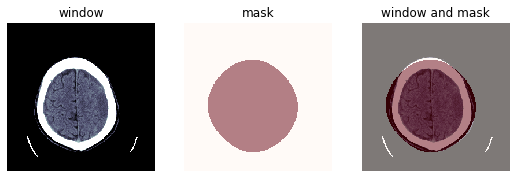

In [ ]:
mask = dcm.mask_from_blur(dicom_windows.brain, sigma=0.9, thresh=0.1, remove_max=True)
wind = dcm.windowed(*dicom_windows.brain)

_,ax = subplots(1,3)
show_image(wind, ax=ax[0], title='window')
show_image(mask, alpha=0.5, cmap=plt.cm.Reds, ax=ax[1], title='mask')
show_image(wind, ax=ax[2])
show_image(mask, alpha=0.5, cmap=plt.cm.Reds, ax=ax[2], title='window and mask');

In [ ]:
#export
def _px_bounds(x, dim):
    c = x.sum(dim).nonzero().cpu()
    idxs,vals = torch.unique(c[:,0],return_counts=True)
    vs = torch.split_with_sizes(c[:,1],tuple(vals))
    d = {k.item():v for k,v in zip(idxs,vs)}
    default_u = tensor([0,x.shape[-1]-1])
    b = [d.get(o,default_u) for o in range(x.shape[0])]
    b = [tensor([o.min(),o.max()]) for o in b]
    return torch.stack(b)

In [ ]:
#export
def mask2bbox(mask):
    no_batch = mask.dim()==2
    if no_batch: mask = mask[None]
    bb1 = _px_bounds(mask,-1).t()
    bb2 = _px_bounds(mask,-2).t()
    res = torch.stack([bb1,bb2],dim=1).to(mask.device)
    return res[...,0] if no_batch else res

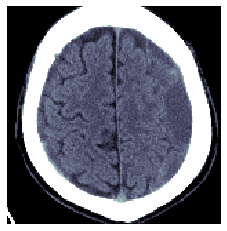

In [ ]:
bbs = mask2bbox(mask)
lo,hi = bbs
show_image(wind[lo[0]:hi[0],lo[1]:hi[1]]);

In [ ]:
#export
def _bbs2sizes(crops, init_sz, use_square=True):
    bb = crops.flip(1)
    szs = (bb[1]-bb[0])
    if use_square: szs = szs.max(0)[0][None].repeat((2,1))
    overs = (szs+bb[0])>init_sz
    bb[0][overs] = init_sz-szs[overs]
    lows = (bb[0]/float(init_sz))
    return lows,szs/float(init_sz)

In [ ]:
#export
def crop_resize(x, crops, new_sz):
    # NB assumes square inputs. Not tested for non-square anythings!
    bs = x.shape[0]
    lows,szs = _bbs2sizes(crops, x.shape[-1])
    if not isinstance(new_sz,(list,tuple)): new_sz = (new_sz,new_sz)
    id_mat = tensor([[1.,0,0],[0,1,0]])[None].repeat((bs,1,1)).to(x.device)
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=UserWarning)
        sp = F.affine_grid(id_mat, (bs,1,*new_sz))+1.
        grid = sp*unsqueeze(szs.t(),1,n=2)+unsqueeze(lows.t()*2.,1,n=2)
        return F.grid_sample(x.unsqueeze(1), grid-1)

torch.Size([1, 128, 128])

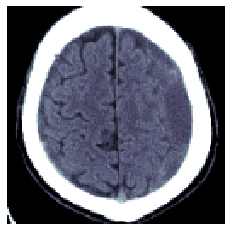

In [ ]:
px256 = crop_resize(to_device(wind[None]), bbs[...,None], 128)[0]
show_image(px256)
px256.shape

Comparing the original image with the image from using the `mask` and `crop_resize` function

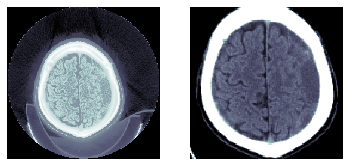

In [ ]:
_,axs = subplots(1,2)
dcm.show(ax=axs[0])
show_image(px256, ax=axs[1]);

In [ ]:
#export
@patch
def to_nchan(x:Tensor, wins, bins=None):
    res = [x.windowed(*win) for win in wins]
    if not isinstance(bins,int) or bins!=0: res.append(x.hist_scaled(bins).clamp(0,1))
    dim = [0,1][x.dim()==3]
    return TensorCTScan(torch.stack(res, dim=dim))

In [ ]:
#export
@patch
def to_nchan(x:DcmDataset, wins, bins=None):
    return x.scaled_px.to_nchan(wins, bins)

`to_nchan` takes a tensor or a dicom as the input and returns multiple one channel images (the first depending on the choosen `windows` and a normalized image).  Setting `bins` to `0` only returns the windowed image.

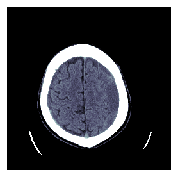

In [ ]:
show_images(dcm.to_nchan([dicom_windows.brain], bins=0))

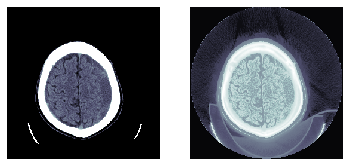

In [ ]:
show_images(dcm.to_nchan([dicom_windows.brain], bins=None))

In [ ]:
#export
@patch
def to_3chan(x:Tensor, win1, win2, bins=None):
    return x.to_nchan([win1,win2],bins=bins)

In [ ]:
#export
@patch
def to_3chan(x:DcmDataset, win1, win2, bins=None):
    return x.scaled_px.to_3chan(win1, win2, bins)

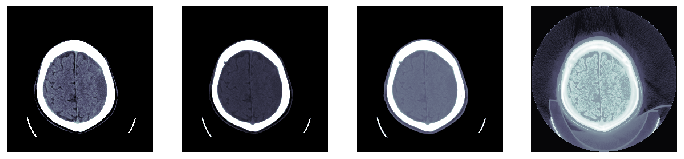

In [ ]:
show_images(dcm.to_nchan([dicom_windows.brain,dicom_windows.subdural,dicom_windows.abdomen_soft]))

In [ ]:
#export
@patch
def save_jpg(x:(Tensor,DcmDataset), path, wins, bins=None, quality=90):
    "Save tensor or dicom image into `jpg` format"
    fn = Path(path).with_suffix('.jpg')
    x = (x.to_nchan(wins, bins)*255).byte()
    im = Image.fromarray(x.permute(1,2,0).numpy(), mode=['RGB','CMYK'][x.shape[0]==4])
    im.save(fn, quality=quality)

In [ ]:
#export
@patch
def to_uint16(x:(Tensor,DcmDataset), bins=None):
    "Convert into a unit16 array"
    d = x.hist_scaled(bins).clamp(0,1) * 2**16
    return d.numpy().astype(np.uint16)

In [ ]:
#export
@patch
def save_tif16(x:(Tensor,DcmDataset), path, bins=None, compress=True):
    "Save tensor or dicom image into `tiff` format"
    fn = Path(path).with_suffix('.tif')
    Image.fromarray(x.to_uint16(bins)).save(str(fn), compression='tiff_deflate' if compress else None)

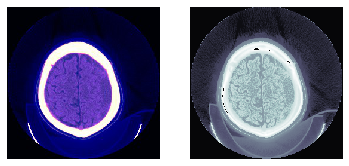

In [ ]:
_,axs=subplots(1,2)
with tempfile.TemporaryDirectory() as f:
    f = Path(f)
    dcm.save_jpg(f/'test.jpg', [dicom_windows.brain,dicom_windows.subdural])
    show_image(Image.open(f/'test.jpg'), ax=axs[0])
    dcm.save_tif16(f/'test.tif')
    show_image(Image.open(str(f/'test.tif')), ax=axs[1]);

In [ ]:
#export
@patch
def set_pixels(self:DcmDataset, px):
    self.PixelData = px.tobytes()
    self.Rows,self.Columns = px.shape
DcmDataset.pixel_array = property(DcmDataset.pixel_array.fget, set_pixels)

In [ ]:
#export
@patch
def zoom(self:DcmDataset, ratio):
    "Zoom image by specified ratio"
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)
        self.pixel_array = ndimage.zoom(self.pixel_array, ratio)

Check to see the current size of the dicom image

In [ ]:
dcm.pixel_array.shape

(256, 256)

(1792, 1792)

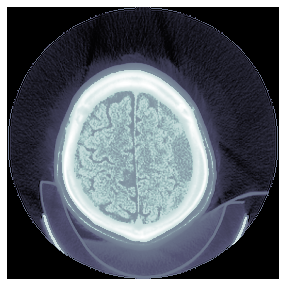

In [ ]:
dcm.zoom(7.0)
dcm.show(); dcm.pixel_array.shape

In [ ]:
#export
@patch
def zoom_to(self:DcmDataset, sz):
    "Change image size to specified pixel size"
    if not isinstance(sz,(list,tuple)): sz=(sz,sz)
    rows,cols = sz
    self.zoom((rows/self.Rows,cols/self.Columns))

In [ ]:
dcm.zoom_to(200); dcm.pixel_array.shape

(200, 200)

In [ ]:
#export
@patch(as_prop=True)
def shape(self:DcmDataset): 
    "Returns the shape of a dicom image as rows and columns"
    return self.Rows,self.Columns

In [ ]:
dcm2 = TEST_DCM.dcmread()
dcm2.zoom_to(90)
test_eq(dcm2.shape, (90,90))

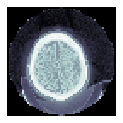

In [ ]:
dcm2 = TEST_DCM.dcmread()
dcm2.zoom(0.25)
dcm2.show()

In [ ]:
#export
def _cast_dicom_special(x):
    cls = type(x)
    if not cls.__module__.startswith('pydicom'): return x
    if cls.__base__ == object: return x
    return cls.__base__(x)

def _split_elem(res,k,v):
    if not isinstance(v,DcmMultiValue): return
    res[f'Multi{k}'] = 1
    for i,o in enumerate(v): res[f'{k}{"" if i==0 else i}']=o

In [ ]:
#export
@patch
def as_dict(self:DcmDataset, px_summ=True, window=dicom_windows.brain):
    "Convert the header of a dicom into a dictionary"
    pxdata = (0x7fe0,0x0010)
    vals = [self[o] for o in self.keys() if o != pxdata]
    its = [(v.keyword,v.value) for v in vals]
    res = dict(its)
    res['fname'] = self.filename
    for k,v in its: _split_elem(res,k,v)
    if not px_summ: return res
    stats = 'min','max','mean','std'
    try:
        pxs = self.pixel_array
        for f in stats: res['img_'+f] = getattr(pxs,f)()
        res['img_pct_window'] = self.pct_in_window(*window)
    except Exception as e:
        for f in stats: res['img_'+f] = 0
        print(res,e)
    for k in res: res[k] = _cast_dicom_special(res[k])
    return res

`as_dict` takes in 2 parameters: `px_summ` which by default is set to `True` and this returns additional stats such as minimal pixel value, maximum pixel value, the mean pixel value and the image standard deviation. The `window` parameter calculates the `pct_in_window` value depending on the `window` that is specified.

In [ ]:
dcm.as_dict(px_summ=True, window=dicom_windows.brain);

In [ ]:
#export
def _dcm2dict(fn, **kwargs): return fn.dcmread().as_dict(**kwargs)

In [ ]:
#export
@delegates(parallel)
def _from_dicoms(cls, fns, n_workers=0, **kwargs):
    return pd.DataFrame(parallel(_dcm2dict, fns, n_workers=n_workers, **kwargs))
pd.DataFrame.from_dicoms = classmethod(_from_dicoms)

Creating a dataframe of the values within the `header` of the dicom

In [ ]:
pneumothorax_source = untar_data(URLs.SIIM_SMALL)
items = get_dicom_files(pneumothorax_source, recurse=True,  folders='train')

In [ ]:
dicom_dataframe = pd.DataFrame.from_dicoms(items); dicom_dataframe.head(1)

,SpecificCharacterSet,SOPClassUID,SOPInstanceUID,StudyDate,StudyTime,AccessionNumber,Modality,ConversionType,ReferringPhysicianName,SeriesDescription,...,LossyImageCompression,LossyImageCompressionMethod,fname,MultiPixelSpacing,PixelSpacing1,img_min,img_max,img_mean,img_std,img_pct_window
0,ISO_IR 100,1.2.840.10008.5.1.4.1.1.7,1.2.276.0.7230010.3.1.4.8323329.6904.1517875201.850819,19010101,000000.00,,CR,WSD,,view: PA,...,01,ISO_10918_1,C:\Users\avird\.fastai\data\siim_small\train\No Pneumothorax\000000.dcm,1,0.168,0,254,160.398039,53.854885,0.087029


## Export -

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()

Converted 00_torch_core.ipynb.
Converted 01_layers.ipynb.
Converted 01a_losses.ipynb.
Converted 02_data.load.ipynb.
Converted 03_data.core.ipynb.
Converted 04_data.external.ipynb.
Converted 05_data.transforms.ipynb.
Converted 06_data.block.ipynb.
Converted 07_vision.core.ipynb.
Converted 08_vision.data.ipynb.
Converted 09_vision.augment.ipynb.
Converted 09b_vision.utils.ipynb.
Converted 09c_vision.widgets.ipynb.
Converted 10_tutorial.pets.ipynb.
Converted 10b_tutorial.albumentations.ipynb.
Converted 11_vision.models.xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_callback.core.ipynb.
Converted 13a_learner.ipynb.
Converted 13b_metrics.ipynb.
Converted 14_callback.schedule.ipynb.
Converted 14a_callback.data.ipynb.
Converted 15_callback.hook.ipynb.
Converted 15a_vision.models.unet.ipynb.
Converted 16_callback.progress.ipynb.
Converted 17_callback.tracker.ipynb.
Converted 18_callback.fp16.ipynb.
Converted 18a_callback.training.ipynb.
Converted 18b_callback.preds.ipynb.
Converted 